<a href="https://colab.research.google.com/github/deep-diver/agentic-system/blob/main/notebooks/document_parse_w_lang_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph
!pip install openai
!pip install chromadb
!pip install -qU langchain-core langchain-upstage

In [161]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.3 MB/s eta 0:00:00


In [136]:
import os

os.environ["UPSTAGE_API_KEY"] = "up_ANcdA1bxF651vbxwBuDFReIen32J2"
UPSTAGE_API_KEY = os.environ["UPSTAGE_API_KEY"]
SERPER_API_KEY = "aabe90976f29be746021f818451820c3a9652ec1"

In [137]:
import chromadb
import numpy as np
from openai import OpenAI
from chromadb import Documents, EmbeddingFunction, Embeddings

chroma_client = chromadb.PersistentClient(path="./chroma_db")
embedding_context_length = 4000

client = OpenAI(
    base_url="https://api.upstage.ai/v1",
    api_key=UPSTAGE_API_KEY
)

class UpstageEmbeddingFunction(EmbeddingFunction[Documents]):
    def __init__(
        self,
        client,
        model_name: str = "embedding-query",
    ):
        self.client = client
        self.model_name = model_name

    def __call__(self, input: Documents) -> Embeddings:
        if not all(isinstance(item, str) for item in input):
            raise ValueError("Solar embedding only supports text documents, not images")

        batch_process_result = self.client.embeddings.create(model=self.model_name, input=input).data
        passage_embedding_list = [i.embedding for i in batch_process_result]
        return np.array(passage_embedding_list, dtype=np.float32)

embedding_fn = UpstageEmbeddingFunction(client)

In [159]:
!rm -rf 2502.00299

In [172]:
import requests
from PyPDF2 import PdfReader, PdfWriter
from langchain_core.tools import tool

@tool
def to_paper_search_agent(paper_title: str):
    """Use this tool to search for paper's arXiv URL on the internet"""
    url = "https://google.serper.dev/search"

    payload = json.dumps({"q": f"{paper_title} on arXiv"})
    headers = {
        'X-API-KEY': SERPER_API_KEY,
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    search_results = response.json()['organic']

    if len(search_results) == 0:
        return "Count not find the URL to download the paper"

    first_result = search_results[0]
    if not first_result['link'].startswith("https://arxiv.org"):
        return "Could not find the URL to download the paper"

    return f"URL to download '{paper_title}': {first_result['link'].replace('abs', 'pdf')}"

def split_pdf_by_pages(input_pdf_path, root_path, pages_per_pdf=10):
    # Open the PDF
    pdf = PdfReader(input_pdf_path)
    total_pages = len(pdf.pages)

    # Calculate number of output PDFs needed
    num_pdfs = (total_pages + pages_per_pdf - 1) // pages_per_pdf

    output_paths = []

    # Split into multiple PDFs
    for i in range(num_pdfs):
        writer = PdfWriter()

        # Calculate start and end pages for this split
        start_page = i * pages_per_pdf
        end_page = min((i + 1) * pages_per_pdf, total_pages)

        # Add pages to writer
        for page_num in range(start_page, end_page):
            writer.add_page(pdf.pages[page_num])

        # Save the split PDF
        output_path = f"{root_path}/{i+1}.pdf"
        with open(output_path, "wb") as output_file:
            writer.write(output_file)
        output_paths.append(output_path)

    return output_paths

def get_document_parse_response(filename, api_key):
    url = "https://api.upstage.ai/v1/document-ai/document-parse"

    headers = {"Authorization": f"Bearer {api_key}"}
    files = {"document": open(filename, "rb")}
    data = {"output_formats": "['markdown']"}

    response = requests.post(url, headers=headers, files=files, data=data)
    upstage_response = json.loads(response.text)
    return upstage_response

def get_md_with_document_parse(root_path, paper_url, paper_id):
    print(1)
    response = requests.get(paper_url)
    # Save the PDF to a temporary file

    print(2)
    pdf_path = f"{root_path}/paper.pdf"
    with open(pdf_path, "wb") as f:
        f.write(response.content)

    print(3)
    split_factor = 1
    split_pdfs = split_pdf_by_pages(pdf_path, root_path, split_factor) # by 10

    print(4)
    markdown = ""
    total_responses = []
    for i, split_pdf in enumerate(split_pdfs):
        upstage_response = get_document_parse_response(split_pdf, UPSTAGE_API_KEY)

        # Append the response to the total_responses list
        total_responses.append({f"page_{i+1 * split_factor}": upstage_response})
        # Also write the response to a JSON file for persistence
        json_output_path = f"{root_path}/response_{i+1}.json"
        with open(json_output_path, "w") as json_file:
            json.dump(upstage_response, json_file, indent=2)

        try:
            markdown += upstage_response['content']['markdown']
        except KeyError:
            pass

    print(5)
    collection = chroma_client.create_collection(name=paper_id, embedding_function=embedding_fn)

    processed_input = []
    if len(markdown) > embedding_context_length:
        chunks = [markdown[i:i+embedding_context_length] for i in range(0, len(markdown), embedding_context_length)]
        processed_input.extend(chunks)
    else:
        processed_input.append(markdown)

    ids = []
    for i in range(len(processed_input)):
        ids.append(f"{paper_id}_{i}")

    collection.add(documents=processed_input, ids=ids)
    return collection

@tool
def to_download_and_parse_paper_agent(paper_url: str):
    """Use this tool to download and parse paper. Use this tool when paper URL is already found."""
    paper_id = paper_url.split("/")[-1]
    root_path = paper_id

    if os.path.exists(root_path):
        print(f"Found cached markdown for {paper_id}")
        return f"we already have the paper content stored in our database in the id of {paper_id}"
        # chunks = get_md_from_fs(paper_id)
    else:
        print(f"No cached markdown found for {paper_id}, parsing from URL")
        os.makedirs(root_path, exist_ok=True)
        _ = get_md_with_document_parse(root_path, paper_url, paper_id)
        return f"we have parsed the paper content and stored in our database in the id of {paper_id}"

@tool
def to_retrive_paper_content_to_answer_question_agent(question: str, paper_id: str):
    """Use this tool to answer question about the paper."""
    collection = chroma_client.get_collection(name=paper_id, embedding_function=embedding_fn)
    results = collection.query(query_texts=[question], n_results=10)
    results_str = ["Below is the retrieved content of the Paper.\n-----------------------------------\n"]
    for i in range(len(results['documents'])):
        results_str.append(f"{i}: {results['documents'][i]}")
    results_str.append("Based on the retrieved content, answer the user query.")
    return "\n".join(results_str)

In [173]:
import json
from typing import Annotated
from typing_extensions import TypedDict
from langchain_upstage import ChatUpstage
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

class State(TypedDict):
    messages: Annotated[list, add_messages]
    found: bool

tools = [
    to_paper_search_agent,
    to_download_and_parse_paper_agent,
    to_retrive_paper_content_to_answer_question_agent
]

llm = ChatUpstage()
llm = llm.bind_tools(tools)

system_prompt = "You are a academic paper analyzer. "
"- Basiclly, you don't have knowledge of the requested paper."
"- Hence, you need to use the provided tools to get the paper information from the internet. "
"- Your job is to find appropriate tool to transfer to based on the user's request and results of tool calls. "
"- If enough information is collected to complete the user request, you should say directly answer to the user request. "

# Define the node that will call the LLM
def chatbot(state: State):
    messages = state['messages']

    # --- Specify the System Prompt Here ---
    system_prompt = "You are a helpful assistant that translates English to French."
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt), # Static system message
        MessagesPlaceholder(variable_name="messages"), # Placeholder for history/user input
    ])

    # Chain the prompt and model
    chain = prompt | llm

    # Invoke the chain with the current messages from the state
    # Note: We pass the messages directly to the placeholder
    response = chain.invoke({"messages": messages})
    print(response)

    # Return the AI's response to be added to the state
    return {"messages": [response]}

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [174]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

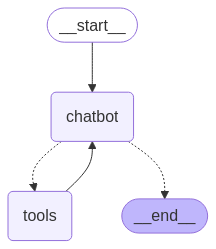

In [175]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [178]:

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            if value["messages"][-1].content:
                print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        break

User: Provide a comprehensive summary of the paper, 'ChunkKV - Semantic-Preserving KV Cache Compression for Efficient Long-Context LLM Inference' on arXiv. 
content='' additional_kwargs={'tool_calls': [{'id': '9822f649-8023-4790-93bb-d4c960443ffc', 'function': {'arguments': '{"paper_title":"ChunkKV - Semantic-Preserving KV Cache Compression for Efficient Long-Context LLM Inference"}', 'name': 'to_paper_search_agent'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 146, 'prompt_tokens': 476, 'total_tokens': 622, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'solar-mini-250123', 'system_fingerprint': None, 'id': 'de158e6d-65a1-4157-9804-64544e4db7e4', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-4ee06396-35f4-49d8-be30-f0e371751bae-0' tool_calls=[{'name': 'to_paper_search_agent', 'args': {'paper_title': 'ChunkKV - Semantic-Preserving KV Cache Compression for Efficient Long-Context LLM Inference